In [2]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 43.9 MB/s eta 0:00:00


Делаем импорт всех нужных инструментов

In [3]:
import mediapipe as mp
import cv2
import torch
import torchvision
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

Обозначим все нужные константы

In [4]:
size_yolo = 224
len_anchors = 1029
classes_length = 80
limit_prop_value = 0.25

Также обозначим имена классов из yolov8

In [5]:
labels = {
    0: u'__background__', 1: u'person', 2: u'bicycle', 3: u'car',
    4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train',
    8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant',
    12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird',
    16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep',
    20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra',
    24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag',
    28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis',
    32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat',
    36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket',
    40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork',
    44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana',
    48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli',
    52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut',
    56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant',
    60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv',
    64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard',
    68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster',
    72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock',
    76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier',
    80: u'toothbrush'
}

Ввелем класс прямуогльников  функции для удобной работы с ними


1.   Класс Rectangle характеризующий bounding box, его score и label
2.   get_rectangles() преобразовывающий многомерный массив в массив Rectangle
3.   non_maximum_suppression() , выполняет соответствующий алгоритм



In [21]:
class Rectangle:
    x_min: int
    y_min: int
    x_max: int
    y_max: int
    value: float
    label: str

    def get_area(self):
        return (self.x_max - self.x_min) * (self.y_max - self.y_min)

    def get_intersection(self, rect):
        res = Rectangle()
        res.x_min = max(self.x_min, rect.x_min)
        res.y_min = max(self.y_min, rect.y_min)
        res.x_max = min(self.x_max, rect.x_max)
        res.y_max = min(self.y_max, rect.y_max)
        return res

    def get_summary(self, rect):
        res = Rectangle()
        res.x_min = min(self.x_min, rect.x_min)
        res.y_min = min(self.y_min, rect.y_min)
        res.x_max = max(self.x_max, rect.x_max)
        res.y_max = max(self.y_max, rect.y_max)
        return res

    def __str__(self):
        res = '{'
        res += str(self.x_min)
        res += ', '
        res += str(self.y_min)
        res += ', '
        res += str(self.x_max)
        res += ', '
        res += str(self.y_max)
        res += '}'
        return res

    def get_label(self):
        return self.label + ': ' + str(self.value)


def get_rectangles(cls, auto_m, width_scales, height_scales):
    rectangles = []
    for ids, value in cls.items():
        current = Rectangle()
        current.x_min = (auto_m[0][ids] - auto_m[2][ids] / 2) * width_scales
        current.y_min = (auto_m[1][ids] - auto_m[3][ids] / 2) * height_scales
        current.x_max = (auto_m[0][ids] + auto_m[2][ids] / 2) * width_scales
        current.y_max = (auto_m[1][ids] + auto_m[3][ids] / 2) * height_scales
        current.value = value[1]
        current.label = labels[value[0]]
        rectangles.append(current)
    return rectangles


def non_maximum_suppression(rectangles, overleap_val):
    betters = []
    rectangles.sort(key=lambda x: 1 / x.value)
    i = 0
    while i < len(rectangles):
        betters.append(rectangles[i])
        j = i + 1
        while j < len(rectangles):
            intersection = rectangles[i].get_intersection(rectangles[j])
            summary = rectangles[i].get_summary(rectangles[j])
            overleap = intersection.get_area() / summary.get_area()
            if overleap > overleap_val:
                rectangles.pop(j)
                j -= 1
            j += 1
        i += 1
    return betters

Теперь считаем и инициализируем граф

In [7]:
config_text = ''
graph_reader = open('graph.pbtxt', 'r')
for line in graph_reader:
    config_text += line

config_text

'input_stream: \'IMAGE:in_stream\'\noutput_stream: \'TENSORS:out_stream\'\n\nnode {\n  calculator: "ImageToTensorCalculator"\n  input_stream: "IMAGE:in_stream"\n  output_stream: "TENSORS:image_tensor"\n\n  options {\n    [mediapipe.ImageToTensorCalculatorOptions.ext] {\n      output_tensor_width: 224\n      output_tensor_height: 224\n      keep_aspect_ratio: false\n      output_tensor_float_range {\n        min: -1.0\n        max: 1.0\n      }\n    }\n  }\n}\n\nnode {\n  calculator: "InferenceCalculator"\n  input_stream: "TENSORS:image_tensor"\n  output_stream: "TENSORS:inference_yolo"\n  options: {\n    [mediapipe.InferenceCalculatorOptions.ext] {\n      model_path: "yolov8n_float32.tflite"\n      delegate { xnnpack {} }\n    }\n  }\n}\n\nnode {\n  calculator: "TensorsToFloatsCalculator"\n  input_stream: "TENSORS:inference_yolo"\n  output_stream: "FLOATS:out_stream"\n}'

Загрузим любой тестовый кадр

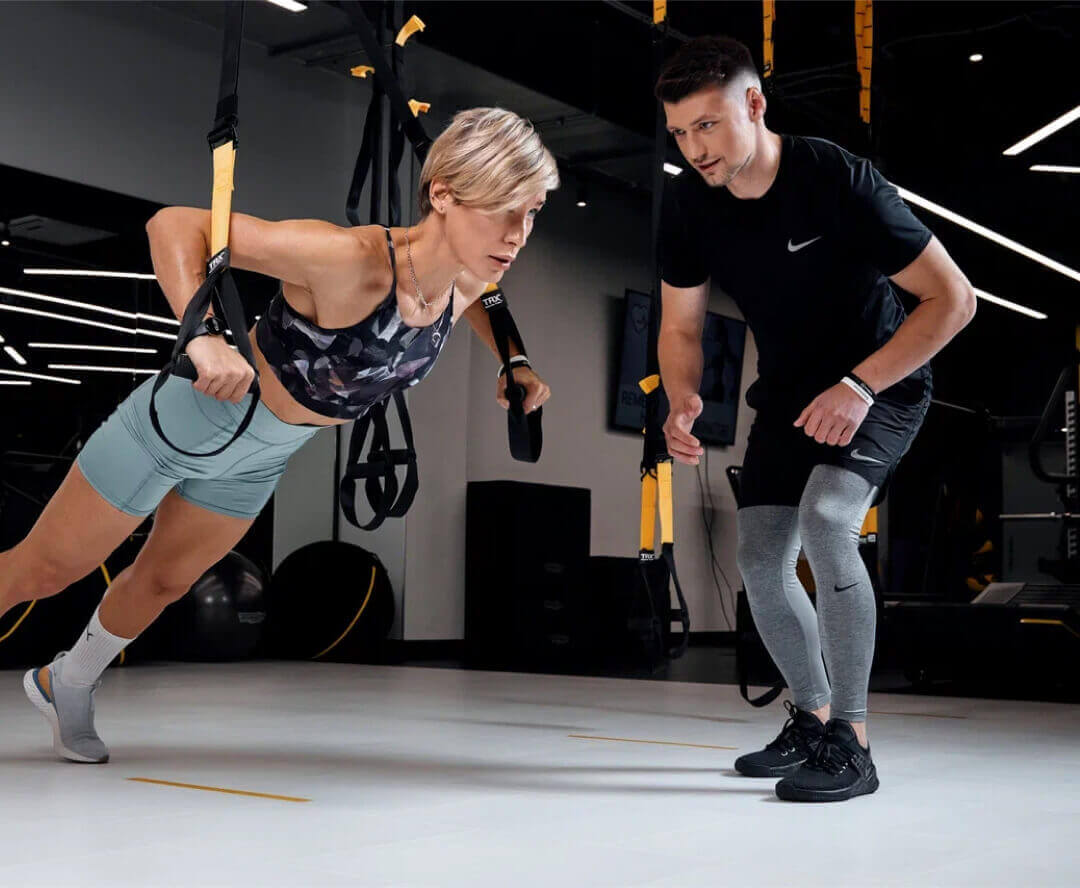

In [8]:
from google.colab.patches import cv2_imshow

# init image
img_path = 'img3.jpg'
img_data = cv2.imread(img_path)
height_scale = img_data.shape[0] / size_yolo
width_scale = img_data.shape[1] / size_yolo
cv2_imshow(img_data)

Настроим выход

In [9]:
# set graph
graph = mp.CalculatorGraph(graph_config=config_text)
output_packets = []
graph.observe_output_stream(
    'out_stream',
    lambda in_stream, packet:
    output_packets.append(packet))

Запускаем процесс графа

In [11]:
# process graph
graph.start_run()
rgb_img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
graph.add_packet_to_input_stream(
    'in_stream',
    mp.packet_creator.create_image_frame(image_format=mp.ImageFormat.SRGB,
                                         data=rgb_img).at(0))

graph.close()

Преобразуем выходной вектор в матрицу

In [12]:
# convert to matrix
automat = mp.packet_getter.get_float_list(output_packets[0])
auto_matrix = []

for i in range(classes_length + 4):
    current_line = []
    for j in range(len_anchors):
        current_line.append(automat[i * len_anchors + j])
    auto_matrix.append(current_line)

auto_matrix

[[6.790449142456055,
  28.696269989013672,
  32.15856170654297,
  37.7427978515625,
  42.48569869995117,
  40.55115509033203,
  55.47744369506836,
  73.17729187011719,
  78.17388916015625,
  76.93948364257812,
  81.85243225097656,
  94.68855285644531,
  99.78948974609375,
  106.71524047851562,
  110.668701171875,
  126.96138763427734,
  141.425537109375,
  148.99050903320312,
  146.571533203125,
  160.25213623046875,
  179.318359375,
  175.55393981933594,
  174.90139770507812,
  177.41015625,
  189.97091674804688,
  201.02804565429688,
  202.96096801757812,
  202.3539581298828,
  6.759153366088867,
  19.44198226928711,
  29.786609649658203,
  41.23705291748047,
  45.271087646484375,
  42.391998291015625,
  50.71099853515625,
  68.94075775146484,
  77.01776123046875,
  76.61617279052734,
  80.23925018310547,
  93.19252014160156,
  94.26544952392578,
  103.19430541992188,
  105.64881896972656,
  110.54866027832031,
  117.73077392578125,
  125.64725494384766,
  141.3612060546875,
  163.62

Выделим доминируещие классы у всех anchors и отбросим шумы

In [14]:
# get max propability
classes = {}
for j in range(len_anchors):
    max_val = -1
    max_class = -1
    for i in range(4, classes_length + 4):
        if auto_matrix[i][j] > max_val:
            max_val = auto_matrix[i][j]
            max_class = i - 3
    if max_val > limit_prop_value:
        classes[j] = [max_class, max_val]

classes

{877: [1, 0.2630714178085327],
 878: [1, 0.2928919196128845],
 990: [1, 0.29626980423927307],
 995: [1, 0.2526491582393646],
 997: [1, 0.4344974160194397],
 998: [1, 0.47039851546287537],
 1001: [1, 0.36319419741630554],
 1002: [1, 0.30874454975128174],
 1004: [1, 0.27964499592781067],
 1005: [1, 0.4494501054286957],
 1008: [1, 0.4198799133300781],
 1009: [1, 0.3042926490306854]}

Высчитываем все bounding boxes и отрисовывем их

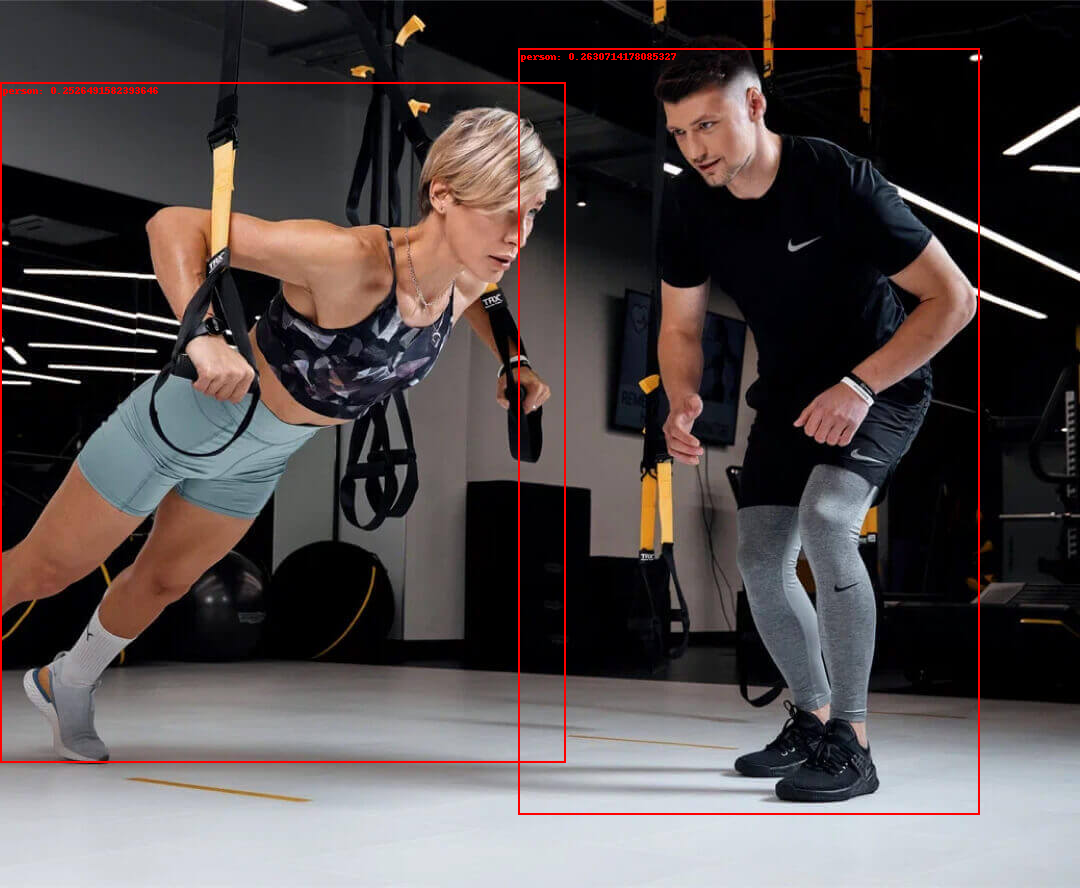

In [20]:
img = read_image(img_path)
bboxes = non_maximum_suppression(get_rectangles(classes, auto_matrix, width_scale, height_scale), 0.3)

for box in bboxes:
    bbox = [[int(box.x_min), int(box.y_min),
             int(box.x_max), int(box.y_max)]]
    bbox = torch.tensor(bbox, dtype=torch.int)
    img = draw_bounding_boxes(img, bbox, width=2, labels=[box.get_label()], colors=(255, 0, 0), fill=False)
img = torchvision.transforms.ToPILImage()(img)
img.show()
